In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from skimage import io

In this experiment, we show how generic Convolutional Neural Network (CNN) features can be extracted and used.

We will be using the keras library which is a full-fledged Deep-Learning library, but is extremely simple to use for basic feature extractions.

This example is based on https://keras.io/applications/

## Extracting CNN Features

In [3]:
# Load Keras
import keras
# Import the Inception network which is a neural network architecture developped by Google (http://arxiv.org/abs/1512.00567)
from keras.applications import inception_v3

Using TensorFlow backend.


In [4]:
# Instantiate the architecture, with pre-trained parameters from ImageNet
# but without the final (top) layer of object classification
# and averaging (avg) the output feature maps to get a constant size feature vector
model = inception_v3.InceptionV3(include_top=False, pooling='avg', weights='imagenet')

Deep learning system usually works with batch of images instead of a single one for efficiency. Here we care about simplicity so below is a helper function for making a single image go through the network. Understanding these details are optional.

In [5]:
def extract_features(img):
    x = np.expand_dims(img.astype(np.float32), axis=0)  # Make a batch of 1 image by expanding the first dimension
    x = inception_v3.preprocess_input(x)  # Preprocess the input image ([0,255] range to [-1,+1])
    return model.predict(x)[0]  # Make the batch goes through the network and convert the batch back to single image

Now let us try to extract features from an image

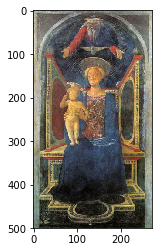

In [6]:
img_test = io.imread('images/madonna/0158f5ff498a4f84b0c6130b3b73f713.jpg')
plt.imshow(img_test)

In [7]:
# Extract the features for the image. The result is a 2048-d vector of numbers
features_test = extract_features(img_test)

(2048,)
[ 0.48469019  0.02819895  0.01363446 ...,  0.0394731   0.25822264
  0.67768115]


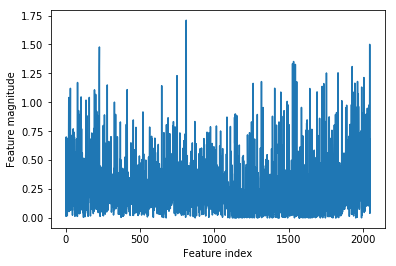

In [8]:
print(features_test.shape)
print(features_test)
plt.plot(features_test)
plt.xlabel('Feature index')
plt.ylabel('Feature magnitude')

Well, that was disappointing... Looks like a random list of 2048 numbers.

In fact, these generic representations are not powerful by themselves. But they are quite efficient when one needs to work in the space of images, which we are going to do next

## Building a simple classifier from CNN descriptors

In this section, we will try to perform the task of trying to detect 'Virgin and Child'-like compositions in paintings (the usefulness of such a task does not really matter for the purpose of that exercise).

The files are in the `images` folder if you want to have a look at it. One folder (madonna) contains the target (or positive) images that we want our system to detect, and the second (random) contains random images. A third folder (test) contains images which are not used during training to test our system at the end.

In [9]:
from glob import glob
from tqdm import tqdm

# Gather the image files in each directory
filenames_madonna = glob('images/madonna/*.jpg')
print("Number of training positive files : {}".format(len(filenames_madonna)))
filenames_random = glob('images/random/*.jpg')
print("Number of training negative files : {}".format(len(filenames_random)))
filenames_test = glob('images/test/*.jpg')
print("Number of test files : {}".format(len(filenames_test)))

Number of training positive files : 17
Number of training negative files : 52
Number of test files : 12


You probably have noticed that only 17 images are used to show the system the concept we are looking for, and 50 random images for the opposite concept. The power of these generic CNN representation is that they have already a high-level understanding of the visual information and can generalize quite easily.

In [10]:
features = []
labels = []
# Extracting features for the positive images
for filename in tqdm(filenames_madonna, desc='Computing features for madonna images'):
    img = io.imread(filename)
    # Add the CNN features to the list
    features.append(extract_features(img))
    # Add the positive label to the list
    labels.append(1.)
# Extracting features for the negative images
for filename in tqdm(filenames_random, desc='Computing features for random images'):
    img = io.imread(filename)
    # Add the CNN features to the list
    features.append(extract_features(img))
    # Add the negative label to the list
    labels.append(0.)
features = np.stack(features)
labels = np.array(labels)

Computing features for random images: 100%|██████████| 52/52 [00:26<00:00,  1.64it/s]


We have processed 69 images, extracting all the features that we stacked in a 2d array whose shape is then [NumberImages, FeatureDimensions]

In [11]:
print(features.shape)
print(features)

(69, 2048)
[[ 0.17847788  0.72711849  0.44633481 ...,  0.33948085  0.26085585
   0.3701022 ]
 [ 0.18191537  0.07456447  0.10084239 ...,  0.66870743  0.58694696
   0.06864632]
 [ 0.22732519  0.56637973  0.43214342 ...,  0.35165951  1.10298228
   0.41459513]
 ..., 
 [ 0.15882011  0.23268189  0.06537315 ...,  0.3339352   0.24411197
   0.79168373]
 [ 0.29967037  0.44088602  0.34969032 ...,  0.63557482  0.57599831
   0.24997491]
 [ 0.22356859  0.24083504  0.18409944 ...,  0.33664873  0.87791008
   0.45706993]]


Additionally, we recorded the training labels (+1 for positive image, 0 for negative image) for the 69 images. The first 17 are the positives and the next 52 are the negatives.

In [12]:
print(labels)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [13]:
from sklearn.svm import SVC

# Instantiate a classifier that will predict a probability
classifier = SVC(probability=True, kernel='linear')
# Train the binary classifier from the extracted features and telling it which images are the good ones with the labels
classifier.fit(features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We now have a classifier that 'supposedly' has learned to distinguish what we want, so let us try it on the test data

Predicting: 100%|██████████| 12/12 [00:08<00:00,  1.57it/s]


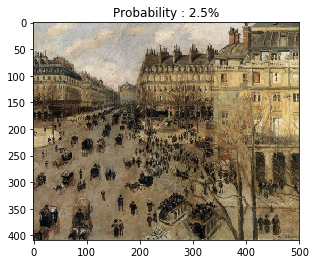

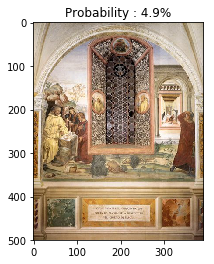

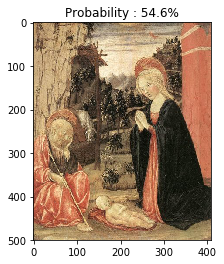

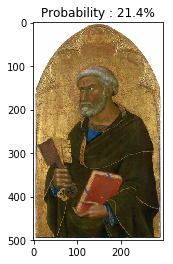

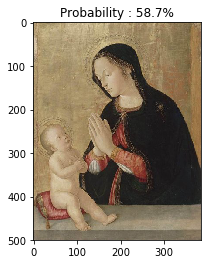

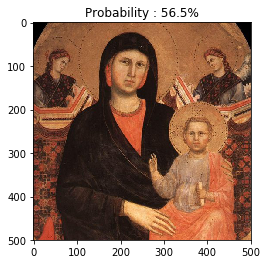

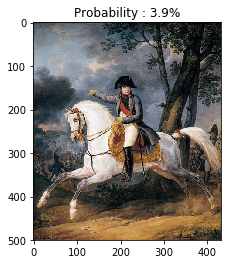

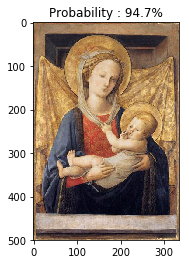

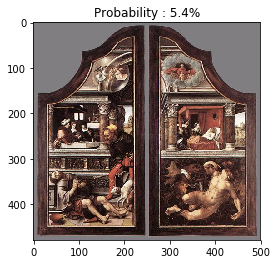

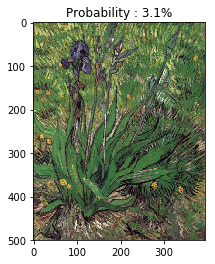

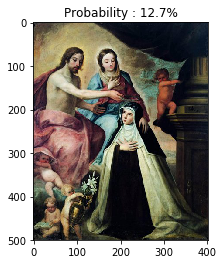

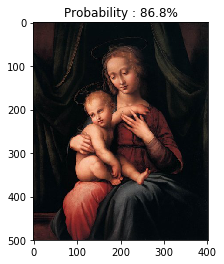

In [14]:
# For each image in the test data
for filename in tqdm(filenames_test, desc="Predicting"):
    # Load the image
    img = io.imread(filename)
    # Extract the features
    feat = extract_features(img)
    # Get the probabilities for the computed features
    probs = classifier.predict_proba(np.expand_dims(feat, axis=0))[0]
    prob_madonna = probs[1]  # probs[0] would be the probability of negative class, probs[1] is for the positive class
    # Display the results
    plt.figure()
    plt.imshow(img)
    plt.title("Probability : {:.01f}%".format(100*prob_madonna))

As you can see the result is not perfect, but remember the system was just trained with less than 70 images!

Bottom line is that CNN features are a good first thing to try for a generic vision task. It is now easy to use a pretrained system and leverage the power of the computer-vision community.

However, always remember that these features do no mean much by themselves.

In [15]:
# For people who are bored, can you compute an embedding from the computed features?
# have a look at http://scikit-learn.org/stable/modules/manifold.html if you do not know where to start